# Description 

This script allows to generate a timeseries of the mean value of a variable for a lake_id for lakes_cci version 2.1.0


INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
      https://admin.climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv </li>
    <li>Name of the variable in the netCDF files</li>
    <liLand mask: the netCDF file containing the mask of the lakes in CCI datase (no changes in the landmask between v2.0.1 and v2.1) is available at: https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>First/last dates</li>
    <li>Version of the dataset to be download (default value 2.1.0)</li>
    </ul>

 Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen,
 M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.;
 Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou,
 H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci):
 Lake products, Version 2.1.0. NERC EDS Centre for Environmental Data
 Analysis, date of citation.
 https://dx.doi.org/10.5285/7fc9df8070d34cacab8092e45ef276f1
 
    
 WARNING: This script is a beta version. All controls on the input parameters
 are not (yet) available. If you find a bug, have a question or a
 suggestion, don't hesitate to contact us, it will be much appreciated :
 cci_lakes.contact@groupcls.com

 to be executed with python version >= 3.9

# key variables

Lakes_cci dataset is a merged product containing multiple variables from different thematic ECVs. The key variables are as follow:

<b>Lake Water Level (LWL):</b>
<ul><li>water_surface_height_above_reference_datum</li></ul>

<b>Lake Water Extent (LWE):</b>
<ul><li>lake_surface_water_extent</li></ul>

<b>Lake Ice Cover (LIC):</b>
<ul><li>lake_ice_cover_class</li></ul>


<b>Lake Surface Water Temperature (LSWT):</b>
<ul><li>lake_surface_water_temperature</li></ul>


<b>Lake Water Leaving Reflectance (LWLR):</b>
<ul><li>chla_mean</li>
<li>turbidity_mean</li>
<li>Rwxxx with xxx: 400, 412, 443, 469, 490, 510, 531, 547, 560, 620, 645, 665, 674, 681, 709, 754, 779, 859, 885, 900, 1020</li></ul>


In [1]:
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import datetime
import matplotlib.pyplot as plt

In [2]:
# list of variables in the netCDF files
lakes_cci_variables = ['Rw1020', 'Rw1020_uncertainty_relative','Rw1020_uncertainty_relative_unbiased',
                       'Rw400','Rw400_uncertainty_relative','Rw400_uncertainty_relative_unbiased',
                       'Rw412','Rw412_uncertainty_relative','Rw412_uncertainty_relative_unbiased',
                       'Rw443','Rw443_uncertainty_relative','Rw443_uncertainty_relative_unbiased',
                       'Rw469','Rw469_uncertainty_relative','Rw469_uncertainty_relative_unbiased',
                       'Rw490','Rw490_uncertainty_relative','Rw490_uncertainty_relative_unbiased',
                       'Rw510','Rw510_uncertainty_relative','Rw510_uncertainty_relative_unbiased',
                       'Rw547','Rw547_uncertainty_relative','Rw547_uncertainty_relative_unbiased',
                       'Rw560','Rw560_uncertainty_relative','Rw560_uncertainty_relative_unbiased',
                       'Rw620','Rw620_uncertainty_relative','Rw620_uncertainty_relative_unbiased',
                       'Rw531','Rw531_uncertainty_relative','Rw531_uncertainty_relative_unbiased',
                       'Rw645','Rw645_uncertainty_relative','Rw645_uncertainty_relative_unbiased',
                       'Rw665','Rw665_uncertainty_relative','Rw665_uncertainty_relative_unbiased',
                       'Rw674','Rw674_uncertainty_relative','Rw674_uncertainty_relative_unbiased',
                       'Rw681','Rw681_uncertainty_relative','Rw681_uncertainty_relative_unbiased',
                       'Rw709','Rw709_uncertainty_relative','Rw709_uncertainty_relative_unbiased',
                       'Rw754','Rw754_uncertainty_relative','Rw754_uncertainty_relative_unbiased',
                       'Rw779','Rw779_uncertainty_relative','Rw779_uncertainty_relative_unbiased',
                       'Rw859','Rw859_uncertainty_relative','Rw859_uncertainty_relative_unbiased',
                       'Rw885','Rw885_uncertainty_relative','Rw885_uncertainty_relative_unbiased',
                       'Rw900','Rw900_uncertainty_relative','Rw900_uncertainty_relative_unbiased',  
                       'chla_mean','chla_uncertainty','turbidity_mean','turbidity_uncertainty',
                       'lake_ice_cover_class','lake_ice_cover_flag','lake_ice_cover_uncertainty',
                       'lake_surface_water_temperature','lswt_uncertainty','lswt_quality_level',
                       'water_surface_height_above_reference_datum','lwl_uncertainty','lwl_quality_flag',
                       'lake_surface_water_extent','lwe_uncertainty','lwe_quality_flag',
                       'time', 'lat', 'lon']

In [7]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.1.nc'

# Id for lake Turkana: 22
lake_id = 22

# variable name
varname = 'lake_surface_water_temperature'

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31

mindate = '2018-07-01'
maxdate = '2018-12-31'

In [8]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2022,12,31)])


In [9]:
# test if varname in list of variables
if not varname in lakes_cci_variables:
    print (f'the varname "{varname}" does not exist in lakes_cci dataset' )

In [10]:
###################################################################
# create mask based on lake_id
###################################################################
mask_nc = nc.Dataset(maskfile)

minx = []
maxx = []
miny = []
maxy = []

nc_var = mask_nc.variables["CCI_lakeid"]
shape =  nc_var.shape

step = int(np.ceil(shape[0] / 10))
steps = list(range(0, shape[0] + step, step))

i = steps[0]
for j in steps[1:]:
    mask = nc_var[i:j, :]
    mask_ind = np.where(mask == lake_id)

    if mask_ind[0].size > 0 or mask_ind[1].size > 0:
        minx.append(np.min(mask_ind[1][:]) - 1)
        maxx.append(np.max(mask_ind[1][:]) + 1)
        miny.append(np.min(mask_ind[0][:]) - 1 + i)
        maxy.append(np.max(mask_ind[0][:]) + 1 + i )
    del mask
    i = j

minx = np.min(minx)
maxx = np.max(maxx)
miny = np.min(miny)
maxy = np.max(maxy)

mask_lake =nc_var[miny : maxy + 1, minx : maxx + 1]
mask_lake[mask_lake != lake_id] = 0
mask_lake[mask_lake == lake_id] = 1


lon = mask_nc.variables['lon'][minx:maxx + 1]
lat = mask_nc.variables['lat'][miny:maxy + 1]

mask_nc.close()

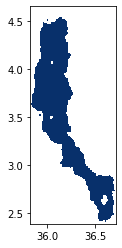

In [11]:

###################################################################
# Plot lake mask
###################################################################

plt.imshow(np.flipud(mask_lake), extent=[lon[0], lon[-1], lat[0], lat[-1]], cmap = 'Blues')
plt.show()

Download process: this can take longtime depending on the selected dates. Each daily file needs to be access to verify if there is (or not) data available for the selected lake.

In [24]:
data = []
version = 2.1
# it can take some  minutes (about 4 min for 6 monthts)
for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")
       
    path = f'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v{version}/merged_product/'
    path += f'{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc?{varname}'
  
    daily_data = xr.open_dataset(path)
    daily_data = daily_data.isel({"lat": slice(miny, maxy),"lon": slice(minx, maxx)})
    
    data.append(daily_data)
    
ds_data = xr.concat(data, dim="time")  

CPU times: user 18.7 s, sys: 8.58 s, total: 27.3 s
Wall time: 4min 14s


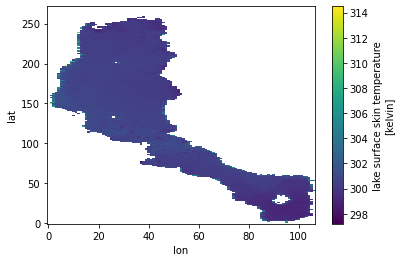

In [25]:
# plot daily values for a selected variable

daily_var = ds_data.isel(time=0)[varname]
daily_var.plot()

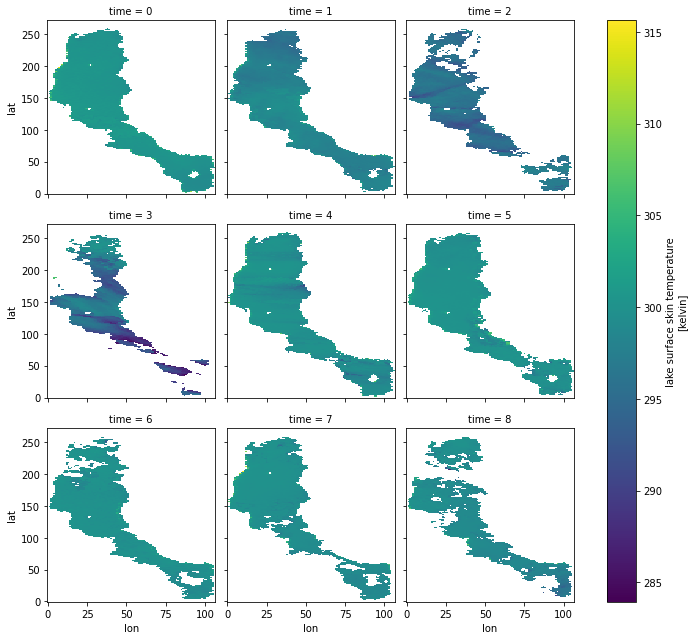

In [26]:
# multiple 2D figures
subset = ds_data.isel(time=slice(0,9 ))[varname]
subset.plot(x='lon', y= 'lat', col='time', col_wrap=3)

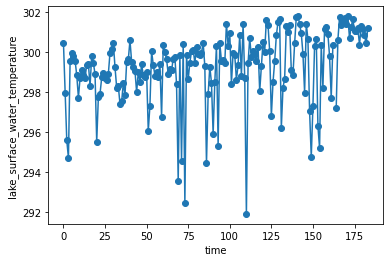

In [27]:
# moyenne par pas de temps :
varname = "lake_surface_water_temperature"
ds_data[varname].mean(("lon", "lat")).plot(marker='o')